In [118]:
import bs4
import pandas as pd
import numpy as np
import requests
from tqdm import tqdm_notebook as tqdm
import math

from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('seaborn-white')

Get appeals for the particular tournament

In [95]:
def get_df_appeal(id_tournament):
    # Prepare dataframe
    columns = ['id', 'q', 'type', 'answer', 'verdict', 'author', 'id_tournament']
    df_appeal = pd.DataFrame(columns=columns)
    
    # Get and parse appeal page
    tmp_appeal = 'https://rating.chgk.info/tournament/{}/appeals/'
    html_appeal = requests.get(tmp_appeal.format(id_tournament)).text
    soup = bs4.BeautifulSoup(html_appeal, 'lxml')
    rows = soup.find_all("table")
    if len(rows) < 2:
        return df_appeal
    else:
        rows = rows[1].find("tbody").find_all("tr")
    
    for row in rows:
        # Get all the fields per row
        try:
            fields = [r.get_text().strip() if i != 4 else r.find('i')["title"] for i, r in enumerate(row.find_all('td'))] + [id_tournament]
        except TypeError:
           # Catch tournaments without appeals
            break
        # Combine in df and append
        appeal = pd.DataFrame({c:[f] for c,f in zip(columns, fields)})
        df_appeal = df_appeal.append(appeal, sort=False)
        
    return df_appeal.reset_index(drop=True)

In [102]:
get_df_appeal(5045)

,id,q,type,answer,verdict,author,id_tournament
0,9274,5-1,Зачёт ответа,Вопрос № 5 черепаха,Апелляция принята,Гаглоев Илья Давидович,5045
1,9275,5-2,Зачёт ответа,Вопрос № 5 черепаха,Апелляция принята,Штанников Вадим Вячеславович,5045
2,9272,11-1,Зачёт ответа,Вопрос № 11 Мрiя,Апелляция отклонена,Ковалёв Виктор Александрович,5045
3,9270,13-1,Зачёт ответа,Вопрос № 13 Дуров,Апелляция отклонена,Корягин Василий Михайлович,5045


Get tournaments list

In [107]:
response = requests.get('http://rating.chgk.info/api/tournaments/')
n_tournaments = int(response.json()['total_items'])
n_pages = math.ceil(n_tournaments / 1000)
n_pages, n_tournaments

(5, 4774)

In [108]:
tournament_ids = []
for p in range(1, n_pages+1):
    tournaments = requests.get('{0}?page={1}'.format(TOURNAMENTS, p)).json()["items"]
    ids = [t['idtournament'] for t in tournaments]
    tournament_ids.extend(ids)
# Check
len(tournament_ids)

4774

Download all appeals

In [109]:
dfs = []
for i, id_tournament in enumerate(tqdm(tournament_ids[::-1])):
    try:
        dfs.append(get_df_appeal(id_tournament))
    except KeyboardInterrupt:
        print('Interrupted')
        break

A Jupyter Widget

In [111]:
df_appeals_full = pd.concat(dfs).reset_index()
print(len(df_appeals_full))
df_appeals_full.head()

7673


,index,id,q,type,answer,verdict,author,id_tournament
0,0,10453,5-1,Снятие вопроса,Вопрос № 5,Апелляция отклонена,5500,NaN
1,0,10442,2-1,Снятие вопроса,Вопрос № 2,Апелляция не рассмотрена,5109,NaN
2,1,10445,21-1,Снятие вопроса,Вопрос № 21,Апелляция не рассмотрена,5109,NaN
3,2,10444,32-1,Снятие вопроса,Вопрос № 32,Апелляция не рассмотрена,5109,NaN
4,0,10458,3-1,Зачёт ответа,Вопрос № 3 бандерилья,Апелляция не рассмотрена,5025,NaN


In [113]:
df_appeals_full.dropna().head()

,index,id,q,type,answer,verdict,author,id_tournament
27,0,10405,27-1,Снятие вопроса,Вопрос № 27,Апелляция отклонена,Евтушков Александр Сергеевич,5510
28,0,10415,16-1,Зачёт ответа,Вопрос № 16 роковые яйца,Апелляция отклонена,Зубкова Ирина Александровна,5397
29,1,10431,23-1,Снятие вопроса,Вопрос № 23,Апелляция отклонена,Попов Алексей Вячеславович,5397
30,2,10430,34-1,Снятие вопроса,Вопрос № 34,Апелляция принята,Дударев Алексей Игоревич,5397
58,0,10384,9-1,Зачёт ответа,Вопрос № 9 кувшин орёл,Апелляция принята,Ермак Вадим Валерьевич,5377


Some appeals do not have an author

In [194]:
df_appeals_full.loc[df_appeals_full.author == ''].head()

,index,id,q,type,answer,verdict,author,id_tournament
1618,0,8771,2-1,Зачёт ответа,Вопрос № 2 наводнение,Апелляция не рассмотрена,,4703
1620,2,8772,14-1,Зачёт ответа,Вопрос № 14 эго,Апелляция не рассмотрена,,4703
1786,1,8630,3-1,Зачёт ответа,Вопрос № 3 Мон Мартр,Апелляция не рассмотрена,,4702
1787,2,8631,7-1,Зачёт ответа,Вопрос № 7 T,Апелляция не рассмотрена,,4702
1788,3,8632,26-1,Зачёт ответа,Вопрос № 26 Основной инстинкт,Апелляция не рассмотрена,,4702


Save df

In [114]:
df_appeals_full.to_csv('./df_appeals.csv')

In [116]:
df_appeals_full_wo_na = df_appeals_full.dropna()

Prepare df for visualization

In [130]:
columns = ['author', 'type', 'Апелляция не рассмотрена', 'Апелляция отклонена', 'Апелляция принята']
authors_df = pd.DataFrame(columns=columns)
for t, group_type in df_appeals_full_wo_na.loc[df_appeals_full_wo_na['verdict'] != 'Апелляция не рассмотрена', :].groupby('type'):
    for author, group_author in group_type.groupby('author'):
        counts = np.unique(group_author.verdict, return_counts=True)
        author_row = {verdict: [count] for verdict, count in zip(*counts)}
        author_row['author'] = [author]
        author_row['type'] = [t]
        author_row = pd.DataFrame(author_row, columns=columns)
        authors_df = authors_df.append(author_row, sort=False)

In [134]:
authors_df['Всего'] = authors_df.iloc[:, 2:].sum(axis=1)

In [136]:
authors_df = authors_df.reset_index(drop=True).fillna(0)
authors_df.head()

,author,type,Апелляция не рассмотрена,Апелляция отклонена,Апелляция принята,Всего
0,,Зачёт ответа,0,57,23,80.0
1,Ааронян Арсен Юрьевич,Зачёт ответа,0,1,0,1.0
2,Абарников Олег Игоревич,Зачёт ответа,0,39,54,93.0
3,Абасалиев Азер Абасали оглы,Зачёт ответа,0,331,174,505.0
4,Абасова Ситара Фахраддин гызы,Зачёт ответа,0,97,58,155.0


In [137]:
authors_df.to_csv('authors_df.csv')

Plot percentages

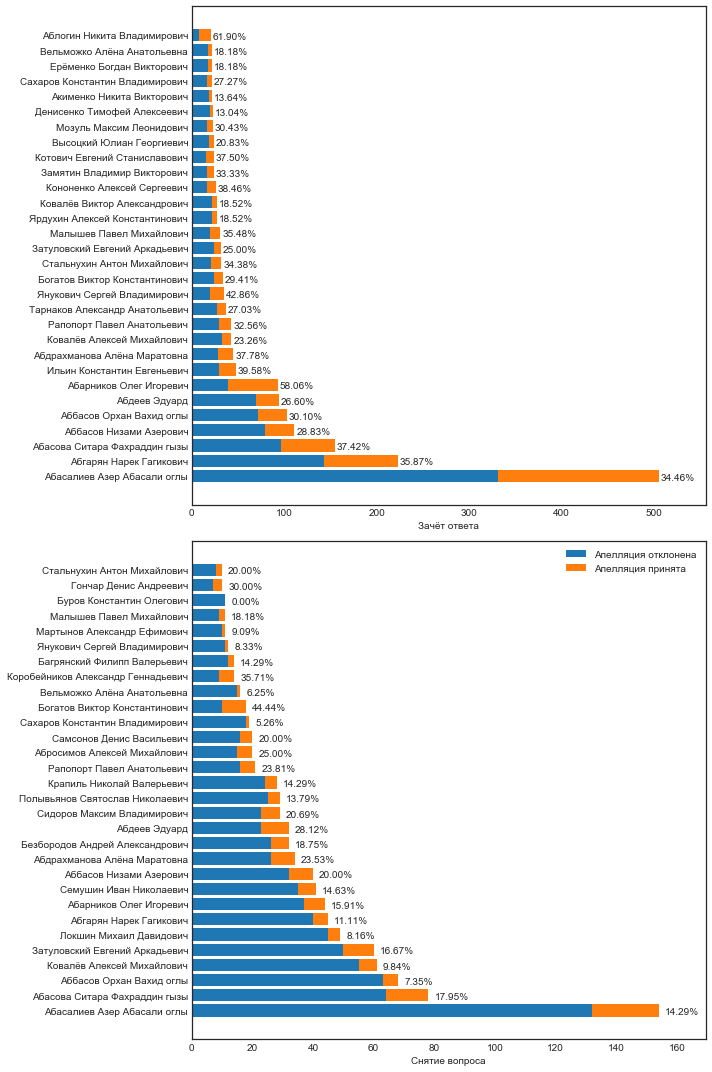

In [198]:
fig, ax = plt.subplots(nrows=2, figsize=(10,15))

for i, t in enumerate(authors_df.type.unique()[:-1]):
    df = authors_df.loc[authors_df.author!='',:].sort_values('Всего', ascending=False).loc[authors_df.type == t, :].head(30)
    ax[i].barh(np.arange(30), df['Апелляция отклонена'], height=0.8, label='Апелляция отклонена' if i else '')
    ax[i].barh(np.arange(30), df['Апелляция принята'], height=0.8, left=df['Апелляция отклонена'], label='Апелляция принята' if i else '')
    for y, (idx, r) in enumerate(df.iterrows()):
        x = int(r['Всего'])
#         print(x)
        ax[i].annotate(xy=(x+2, y-0.25), s='{:.2f}%'.format(r['Апелляция принята'] * 100 / r['Всего']))
        
    ax[i].set_yticks(np.arange(30))
    ax[i].set_yticklabels(df.author.tolist())
    ax[i].set_xlabel(t)
    ax[i].set_xlim(0, max(df['Всего'])*1.1)

plt.tight_layout()
plt.legend()
plt.show()